In [1]:
import copy
import numpy as np
import laspy as lp
import open3d as o3d
import pyvista as pv
import matplotlib.path as mpath 

def to_open3d(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def las_to_open3d(las_source_path, target_path):
    las = lp.read(las_source_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    pcd = to_open3d(points)
    o3d.io.write_point_cloud(target_path, pcd)

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])


def get_ground_points(las_source_path, salmuera):
    las = lp.read(las_source_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))
    one_return = data_points[(data_points[:, -1] == 1)][:, :3]
    return one_return[one_return[:,2] > salmuera] 

def get_ground_points(las_source_path, perimetro, poza):
    # Leer el archivo LAS
    las = lp.read(las_source_path)
    
    # Extraer coordenadas XYZ y colores RGB
    points = np.vstack((las.x, las.y, las.z)).transpose()
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    
    # Combinar datos (XYZ + RGB + metadata)
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))
    
    # Filtrar puntos de único retorno (XYZRGB)
    single_returns = data_points[data_points[:, -1] == 1][:, :6]  # 6 columnas: X,Y,Z,R,G,B
    
    # Definir el polígono del perímetro
    poly_coords = [
        perimetro[poza]['p1'],
        perimetro[poza]['p2'],
        perimetro[poza]['p3'],
        perimetro[poza]['p4']
    ]
    polygon = mpath.Path(poly_coords)
    
    # Crear máscara: True para puntos FUERA del polígono
    mask = ~polygon.contains_points(single_returns[:, :2])  # Invertir la máscara con ~
    
    return single_returns[mask] 

def get_point(path, perimetro, poza, transformed=False):
    las = lp.read(path)
    
    points = np.vstack((las.x, las.y, las.z)).transpose()

    poly_coords = [
        perimetro[poza]['p1'],
        perimetro[poza]['p2'],
        perimetro[poza]['p3'],
        perimetro[poza]['p4']
    ]
    
    polygon_path = mpath.Path(poly_coords)
    
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.intensity, -1),
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))
    
    single = data_points[data_points[:, -1] == 1][:, :6]  # Mantener XYZRGB
    mask = polygon_path.contains_points(single[:, :2])  # Usar solo XY para el polígono
    return single[mask] 


def view_cloud_pv(points):
    xyz = points[:, :3]  # Primeras 3 columnas: X, Y, Z
    rgb = points[:, 3:6]  # Columnas 4-6: R, G, B
    
    # Normalizar RGB de 16-bit (LAS) a 8-bit (0-255)
    if np.issubdtype(rgb.dtype, np.integer) and rgb.max() > 255:
        rgb = (rgb // 256).astype(np.uint8)  # Conversión a 8-bit
    
    # Crear objeto PolyData con coordenadas
    cloud = pv.PolyData(xyz)
    
    # Añadir colores RGB como array asociado a los puntos
    cloud["RGB"] = rgb.astype(np.uint8)  # Asegurar tipo uint8
    
    # Configurar plotter
    plotter = pv.Plotter()
    plotter.add_mesh(
        cloud,
        scalars="RGB",  # Usar el array RGB
        rgb=True,       # Indicar que son canales RGB
        point_size=3,   # Tamaño de los puntos
        opacity=1       # Opacidad total
    )
    
    plotter.show()

def fast_global_registration(source, target, voxel_size=0.5):
    # 1. Downsampling agresivo
    source_down = source.voxel_down_sample(voxel_size)
    target_down = target.voxel_down_sample(voxel_size)
    
    # 2. Normales rápidas con parámetros optimizados
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*3, max_nn=20))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*3, max_nn=20))
    
    # 3. Cálculo rápido de características
    source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        source_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=50))
    target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        target_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=50))
    
    # 4. RANSAC acelerado
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        max_correspondence_distance=voxel_size*2,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        ransac_n=3,  # Mínimo de puntos para estimación
        checkers=[
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(voxel_size*2)
        ],
        criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.99)
    )
    
    return result.transformation

import numpy as np

def generate_dem(points, rasante, x_min, x_max, y_min, y_max, grid_spacing=None):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    #z = np.clip(z, 0, 4)

    # Calcular espaciado de la grilla
    if grid_spacing is None:
        dx = np.diff(x)
        dy = np.diff(y)
        point_spacing = np.mean(np.sqrt(dx**2 + dy**2))
        grid_spacing = point_spacing

    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan

    return dem

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
perimetro = {
    'pam2':{
        'p1': (558909.423, 7394732.635),
        'p2': (558909.423, 7394814.242),
        'p3': (558850.050, 7394814.242),
        'p4': (558850.050, 7394732.635)
    },
    '2a':{
        'p1': (559229.350, 7394639.900),
        'p2': (559229.350, 7394912.400),
        'p3': (559333.00, 7394912.400),
        'p4': (559333.00, 7394639.900)
    },
    '3a':{
        'p1': (559353.270, 7394639.900),
        'p2': (559353.270, 7394912.350),
        'p3': (559591.970, 7394912.350),
        'p4': (559591.970, 7394639.900)
    },
    '5a':{
        'p1': (559871.270, 7394639.900),	
        'p2': (559871.270, 7394912.350),
        'p3': (560109.970, 7394912.350),
        'p4': (560109.970, 7394639.900)
    },
    '6a':{
        'p1': (560130.230, 7394639.900),
        'p2': (560130.230, 7394912.200),
        'p3': (560428.900, 7394912.200),
        'p4': (560428.900, 7394639.900)
    },
    '7a':{
        'p1': (560449.270, 7394639.900),
        'p2': (560449.270, 7394912.350),	
        'p3': (560747.970, 7394912.350),	
        'p4': (560747.970, 7394639.900)
    }
}

rasantes = {
    'pam2-3003': 2300.572,
    'pam2-1404': 2300.572,

    '2a-3003': 2300.416,
    '2a-1404': 2300.416,

    '3a-3003': 2300.326,
    '3a-1404': 2300.326,

    '5a-3103': 2300.290,
    '5a-1504': 2300.290,  

    '6a-3103': 2300.350,
    '6a-1504': 2300.350,  

    '7a-3103': 2300.437,
    '7a-1504': 2300.260
}

salmueras = {
    'pam2-3003': 2302.185,
    'pam2-1404': 2301.923,

    '2a-3003': 2301.129,
    '2a-1404': 2300.416,

    '3a-3003': 2300.978,
    '3a-1404': 2300.953,

    '5a-3103': 2300.455,
    '5a-0104': 2300.457,
    '5a-1504': 2300.479,

    '6a-3103': 2300.909,
    '6a-0104': 2300.909,
    '6a-1504': 2300.350,

    '7a-3103': 2301.189,
    '7a-0104': 2301.194,
    '7a-1504': 2301.071
}

sales = {
    'pam2-3003': 2301.817,
    'pam2-1404': 2301.923,

    '2a-3003': 2300.971,
    '2a-1404': 2300.971,

    '3a-3003': 2300.757,
    '3a-1404': 2300.790,

    '5a-3103': 2300.290,
    '5a-0104': 2300.298,
    '5a-1504': 2300.298,

    '6a-3103': 2300.804,
    '6a-0104': 2300.930,
    '6a-1504': 2300.930,

    '7a-3103': 2300.991,    
    '7a-0104': 2300.814,
    '7a-1504': 2300.814
}

asalmuera = {
    'pam2-3003': 36.80,
    'pam2-1404': 0.0,

    '2a-3003': 15.80,
    '2a-1404': 0.0,

    '3a-3003': 22.10,
    '3a-1404': 15.81,

    '5a-3103': 16.50,
    '5a-0104': 15.87,
    '5a-1504': 17.56,

    '6a-3103': 8.92,
    '6a-0104': 8.90,
    '6a-1504': 0.00,

    '7a-3103': 19.21,
    '7a-0104': 20.00,
    '7a-1504': 25.70
}


POZA = 'pam2'
FECHAV1 = '1404'
FECHAV2 = '1404'
THRESHOLD = 0.02

RASANTEV1 = rasantes.get(f'{POZA}-{FECHAV1}', None)
RASANTEV2 = rasantes.get(f'{POZA}-{FECHAV2}', None)

SALMUERAV1 = salmueras.get(f'{POZA}-{FECHAV1}', None)
SALMUERAV2 = salmueras.get(f'{POZA}-{FECHAV2}', None)

SALV1 = sales.get(f'{POZA}-{FECHAV1}', None)
SALV2 = sales.get(f'{POZA}-{FECHAV2}', None)

ASALMUERAV1 = asalmuera.get(f'{POZA}-{FECHAV1}', None)
ASALMUERAV2 = asalmuera.get(f'{POZA}-{FECHAV2}', None)

print('rasantes')
print(RASANTEV1, RASANTEV2)
print('salmuera')
print(SALMUERAV1, SALMUERAV2)
print('sales')
print(SALV1, SALV2)
print('altura salmuera')
print(ASALMUERAV1, ASALMUERAV2)
print('crecimiento')
print((SALV2-SALV1)*100)
print('altura sal')
print((SALV1-RASANTEV1)*100, (SALV2-RASANTEV2)*100)

TRANS_INIT = np.asarray([[1.0, 0.0, 0.0, 0.0], 
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0], 
                         [0.0, 0.0, 0.0, 1.0]])

rasantes
2300.572 2300.572
salmuera
2301.923 2301.923
sales
2301.923 2301.923
altura salmuera
0.0 0.0
crecimiento
0.0
altura sal
135.0999999999658 135.0999999999658


In [6]:
source_path = '/home/diego/Downloads/data_sqm/14-04-2025/14-04-25 100m&150m 100Khz 10ms/pam-2_100m_10ms_100khz_plena-luz_0_0_poza.las'
target_path = '/home/diego/Downloads/data_sqm/14-04-2025/14-04-25 100m&150m 100Khz 10ms (2)/pam-2v2_100m_10ms_100khz_plena-luz_0_0_poza.las'

In [7]:
src_ground_points = get_ground_points(source_path, perimetro, POZA) 
src_ground_points = src_ground_points[:,:3]
pcd_src_ground_points = to_open3d(src_ground_points)

dst_ground_points = get_ground_points(target_path, perimetro, POZA) 
dst_ground_points = dst_ground_points[:,:3]
pcd_dst_ground_points = to_open3d(dst_ground_points)

#VOXEL_SIZE = 1.0  
#THRESHOLD = VOXEL_SIZE * 1.5
#TRANS_INIT = fast_global_registration(pcd_src_ground_points, pcd_dst_ground_points, VOXEL_SIZE) 

pcd_src_ground_points.estimate_normals()
pcd_dst_ground_points.estimate_normals()

print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
            pcd_src_ground_points, 
            pcd_dst_ground_points, 
            THRESHOLD, 
            TRANS_INIT,
            o3d.pipelines.registration.TransformationEstimationPointToPlane()
        )


transformation = copy.deepcopy(reg_p2l.transformation)

print("Transformation is:")
print(transformation)

las = lp.read(source_path)
src_las_data_points_transformed = np.dot(transformation[:3, :3], las.xyz.T).T + transformation[:3, 3]

las.x = src_las_data_points_transformed[:, 0]
las.y = src_las_data_points_transformed[:, 1]
las.z = src_las_data_points_transformed[:, 2]

source_las_transformed = source_path.replace('.las', '_transformed.las')
print(f"Saving transformed LAS to {source_las_transformed}")
las.write(source_las_transformed)

Apply point-to-plane ICP
Transformation is:
[[ 9.99999925e-01  2.44561014e-04  2.99529002e-04 -1.80919618e+03]
 [-2.44616060e-04  9.99999953e-01  1.83750797e-04  1.36633497e+02]
 [-2.99484049e-04 -1.83824052e-04  9.99999938e-01  1.52673331e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Saving transformed LAS to /home/diego/Downloads/data_sqm/14-04-2025/14-04-25 100m&150m 100Khz 10ms/pam-2_100m_10ms_100khz_plena-luz_0_0_poza_transformed.las


In [8]:
points_a = get_point(source_las_transformed, perimetro, POZA)[:,:3]
points_b = get_point(target_path, perimetro, POZA)[:,:3]

xmin, xmax = np.min([np.min(points_a[:,0]), np.min(points_b[:,0])]), np.max([np.max(points_a[:,0]), np.max(points_b[:,0])])
ymin, ymax = np.min([np.min(points_a[:,1]), np.min(points_b[:,1])]), np.max([np.max(points_a[:,1]), np.max(points_b[:,1])])

dem_a = generate_dem(points_a, RASANTEV1, xmin, xmax, ymin, ymax, grid_spacing=0.17)
dem_b = generate_dem(points_b, RASANTEV2, xmin, xmax, ymin, ymax, grid_spacing=0.17)

In [9]:
# import matplotlib.pyplot as plt 
# points_a = get_point(source_las_transformed, perimetro, POZA)[:,:3]
# points_b = get_point(target_path, perimetro, POZA)
# mask_intensity = points_b[:,3] > 48500 
# points_b = points_b[mask_intensity]
# plt.hist(points_b[:,3], bins=30)
# plt.show()
# plt.hist(points_b[:,2], bins=30)
# plt.show()
# points_b = points_b[:,:3]

# xmin, xmax = np.min([np.min(points_a[:,0]), np.min(points_b[:,0])]), np.max([np.max(points_a[:,0]), np.max(points_b[:,0])])
# ymin, ymax = np.min([np.min(points_a[:,1]), np.min(points_b[:,1])]), np.max([np.max(points_a[:,1]), np.max(points_b[:,1])])

# dem_a = generate_dem(points_a, RASANTE, xmin, xmax, ymin, ymax, grid_spacing=0.17)
# dem_b = generate_dem(points_b, RASANTE, xmin, xmax, ymin, ymax, grid_spacing=0.17)

In [10]:
ASALV1 = np.mean(points_a[:,2] - RASANTEV1)*100
ASALV2 = np.mean(points_b[:,2] - RASANTEV2)*100

print(f'vuelo {FECHAV1} sal promedio: {ASALV1}')
print(f'vuelo {FECHAV2} sal promedio: {ASALV2}')
print(f'diferencia altura sal {FECHAV1} - {FECHAV2}: {ASALV2 - ASALV1}')

xx =  dem_b - dem_a 
xx = xx[~np.isnan(xx)]
print(f'diferencia promedio: {np.mean(xx)*100}')

vuelo 1404 sal promedio: 149.11347274046466
vuelo 1404 sal promedio: 138.17879083571188
diferencia altura sal 1404 - 1404: -10.934681904752779
diferencia promedio: -10.81783742592305


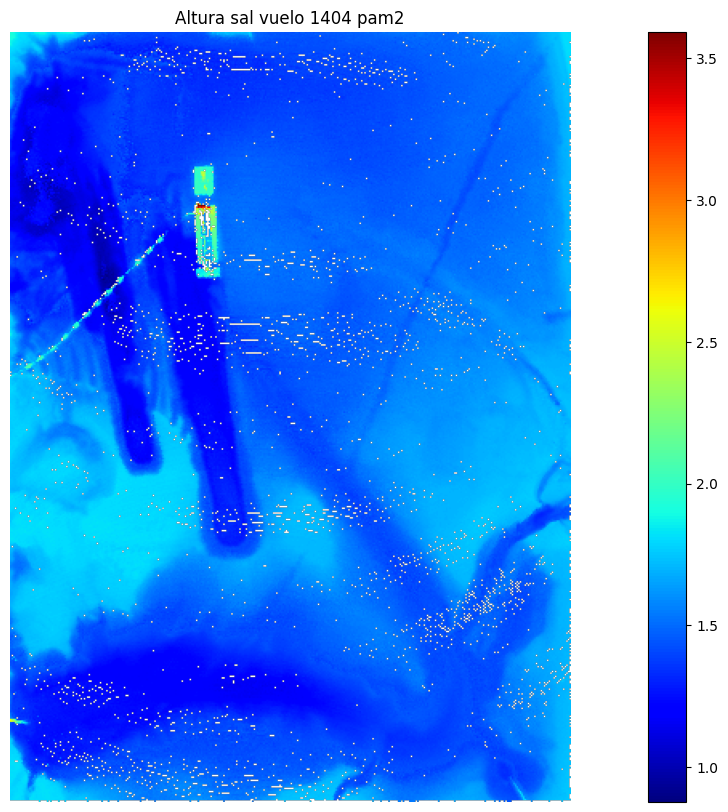

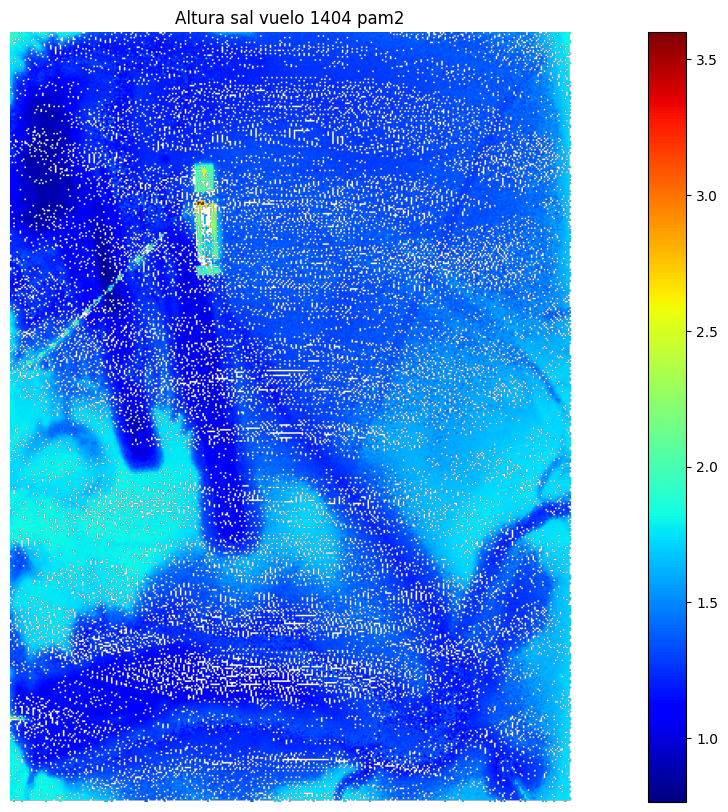

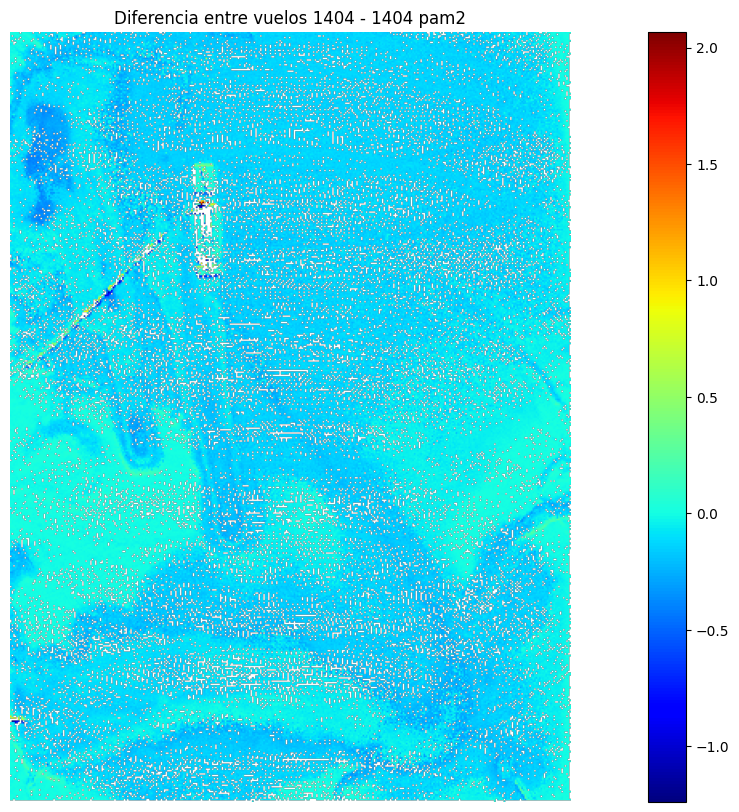

In [11]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(dem_a, cmap='jet')
plt.colorbar()
plt.title(f'Altura sal vuelo {FECHAV1} {POZA}')  
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(dem_b, cmap='jet')
plt.colorbar()
plt.title(f'Altura sal vuelo {FECHAV2} {POZA}')  
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(dem_b - dem_a, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f'Diferencia entre vuelos {FECHAV1} - {FECHAV2} {POZA}')  
plt.show()


In [12]:
def bresenham_line(start=(10, 10), end=(10, 60)):
    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points

h, w = dem_a.shape
line = bresenham_line(start=(0, 0), end=(h-1,w-1))

(465, 2) (422, 2)


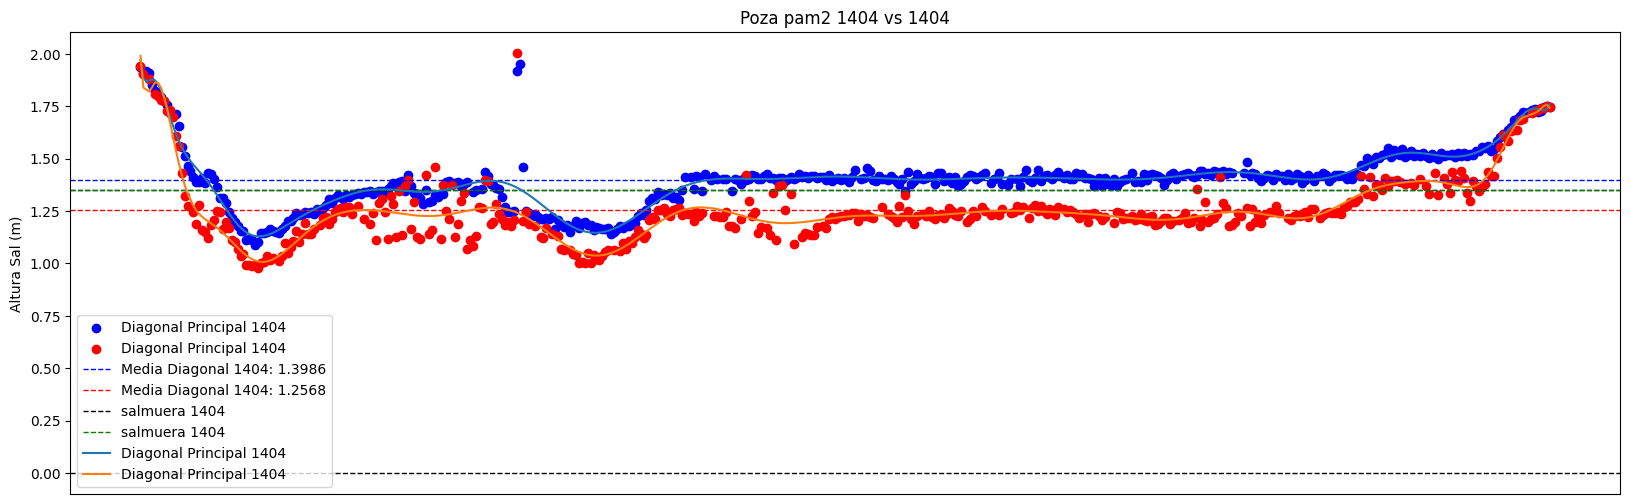

In [13]:
from numpy.polynomial.polynomial import Polynomial

z_d1 = np.array([(idx, dem_a[x][y]) for idx, (x, y) in enumerate(line) if not np.isnan(dem_a[x][y])])
z_d2 = np.array([(idx, dem_b[x][y]) for idx, (x, y) in enumerate(line) if not np.isnan(dem_b[x][y])])
print(z_d1.shape, z_d2.shape)

degree = 30
poly_d1 = Polynomial.fit(z_d1[:,0], z_d1[:,1], degree)
poly_d2 = Polynomial.fit(z_d2[:,0], z_d2[:,1], degree)

x_new_d1 = z_d1[:,0]
x_new_d2 = z_d2[:,0]
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1[:,1])
mean_diagonal2 = np.mean(z_d2[:,1])

plt.figure(figsize=(20, 6))
plt.scatter(z_d1[:,0], z_d1[:,1],color='blue' ,label=f'Diagonal Principal {FECHAV1} ')
plt.scatter(z_d2[:,0], z_d2[:,1],color='red', label=f'Diagonal Principal {FECHAV2}')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Media Diagonal {FECHAV1}: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Media Diagonal {FECHAV2}: {mean_diagonal2:.4f}')
plt.axhline(SALMUERAV1-RASANTEV1, color='black', linestyle='--', linewidth=1, label=f'salmuera {FECHAV1}')
plt.axhline(SALMUERAV2-RASANTEV2, color='green', linestyle='--', linewidth=1, label=f'salmuera {FECHAV2}')
plt.plot(x_new_d1, z_new_d1, label=f'Diagonal Principal {FECHAV1}')
plt.plot(x_new_d2, z_new_d2, label=f'Diagonal Principal {FECHAV2}')
plt.title(f'Poza {POZA} {FECHAV1} vs {FECHAV2}')
plt.ylabel('Altura Sal (m)')
plt.xticks([])
plt.legend()
plt.show()

In [14]:
from PIL import Image
import json

OUTPUTS_PATH = '/home/diego/Downloads/results'

pil_image_z = Image.fromarray(dem_a)
pil_image_z.save(f'{OUTPUTS_PATH}/{POZA}_{FECHAV1}.tiff')

pil_image_z = Image.fromarray(dem_b)
pil_image_z.save(f'{OUTPUTS_PATH}/{POZA}_{FECHAV2}.tiff')

for dem, date, csalmuera, csal, asal, asalmuera, rasante in zip([dem_a, dem_b], [FECHAV1, FECHAV2], [SALMUERAV1, SALMUERAV2],
                                                       [SALV1, SALV2], [ASALV1, ASALV2], [ASALMUERAV1, ASALMUERAV2],
                                                       [RASANTEV1, RASANTEV2]):
    h, w = dem.shape
    d1 = bresenham_line(start=(0, 0), end=(h-1,w-1))
    d2 = bresenham_line(start=(h-1, 0), end=(0,w-1))
    dem_d1 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d1) if not np.isnan(dem[x][y])])
    dem_d2 = np.array([(idx, dem[x][y]) for idx, (x, y) in enumerate(d2) if not np.isnan(dem[x][y])])

    result = {
        'altura sal': asal,
        'altura salmuera': asalmuera,
        'cota salmuera': csalmuera,
        'cota sal':csal,
        'rasante': rasante,
        
        'diagonal1':{
            'unit':     '[m]',
            'mean':     float(np.mean(dem_d1[:,1])),
            'x_axis':   dem_d1[:,0].tolist(),
            'y_axis':   dem_d1[:,1].tolist()

        },
        'diagonal2':{
            'unit':     '[m]',
            'mean':     float(np.mean(dem_d2[:,1])),
            'x_axis':   dem_d2[:,0].tolist(),
            'y_axis':   dem_d2[:,1].tolist()
        }
    }

    with open(f'{OUTPUTS_PATH}/{POZA}_{date}.json', 'w') as f:
        json.dump(result, f, indent=4)
